# Lab3

## Import Libraries

In [231]:
import pandas as pd

import numpy as np
from numpy.typing import NDArray


from geopy.distance import geodesic

import networkx as nx
from pyvis.network import Network


from itertools import combinations


from icecream import ic

import os

# from IPython.display import display, HTML

# import logging
# logging.basicConfig(level=logging.DEBUG)

## Setup Dataframe

## Prelude


In [232]:
def warmup_cache() -> None:
    for country in os.listdir("cities"):
        if not os.path.exists(f".cache/{country.split(".")[0]}_dist_matrix.npy"):
            load_country_and_distance_matrix(country.split(".")[0])


def load_country(country_name: str) -> pd.DataFrame:
    if not os.path.exists(f"cities/{country_name}.csv"):
        raise FileNotFoundError(f"cities/{country_name}.csv not found")
    return pd.read_csv(f"cities/{country_name}.csv", header=None, names=["name", "lat", "lon"])


def load_country_and_distance_matrix(country_name: str) -> tuple[pd.DataFrame, NDArray[np.float64]]:
    os.makedirs(".cache", exist_ok=True)

    COUNTRY = load_country(country_name)

    cache_path = f".cache/{country_name}_dist_matrix.npy"

    if os.path.exists(cache_path):
        return COUNTRY, np.load(cache_path)
    else:
        DIST_MATRIX: NDArray[np.float64] = np.zeros((len(COUNTRY), len(COUNTRY)), dtype=np.float64)
        for c1, c2 in combinations(COUNTRY.itertuples(), 2):
            DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
                (c1.lat, c1.lon), (c2.lat, c2.lon)
            ).km
        np.save(cache_path, DIST_MATRIX)
        return COUNTRY, DIST_MATRIX

In [233]:
# Create missing cache files for all countries
warmup_cache()
COUNTRY, DIST_MATRIX = load_country_and_distance_matrix(country_name="italy")
COUNTRY.head()

,name,lat,lon
0,Ancona,43.60,13.50
1,Andria,41.23,16.29
2,Bari,41.12,16.87
3,Bergamo,45.70,9.67
4,Bologna,44.50,11.34


## Setup City Network

ic| median: np.float64(367.0694334013403)


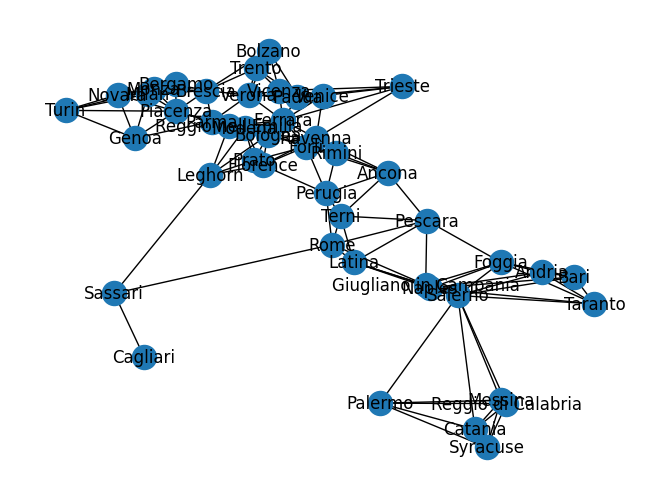

In [242]:
median: np.float64 = np.median(DIST_MATRIX.reshape(1, -1))
ic(median)
G = nx.Graph()

for i, row in enumerate(DIST_MATRIX):
    closest_indices = np.argsort(row)[:6]  # Get indices of the 5 closest cities + itself
    for j in closest_indices:
        if i != j and DIST_MATRIX[i, j] <= median:
            if np.isinf(DIST_MATRIX[i, j]):
                ic(i, j, DIST_MATRIX[i, j])
                raise ValueError("Distance is infinite")
            G.add_edge(
                COUNTRY.iloc[i]["name"],
                COUNTRY.iloc[j]["name"],
                # pos parameter is not needed here
                # Normalize the weight
                weight=int((DIST_MATRIX[i, j] / median) * 5),
                length=DIST_MATRIX[i, j],
            )

assert nx.is_connected(G), "At least one city is not connected to the graph."
assert G.number_of_nodes() == len(
    COUNTRY
), "The number of nodes in the graph does not match the number of cities in the dataframe."

# Create a dictionary for positions
pos = {COUNTRY.iloc[i]["name"]: (COUNTRY.iloc[i]["lon"], COUNTRY.iloc[i]["lat"]) for i in range(len(COUNTRY))}

# Draw the graph with positions
nx.draw(G, pos, with_labels=True)

In [235]:
def a_star(graph, start, goal, heuristic) -> nx.Graph:
    if start not in graph.nodes or goal not in graph.nodes:
        raise ValueError("Start or goal node not in graph.")

    open_set = {start}
    came_from = {}
    g_score = {node: float('inf') for node in graph.nodes}
    g_score[start] = 0
    f_score = {node: float('inf') for node in graph.nodes}
    f_score[start] = heuristic(start, goal)

    while open_set:
        current = min(open_set, key=lambda node: f_score[node])

        if current == goal:
            path = []
            while current is not None:
                path.append(current)
                current = came_from.get(current)
            path = path[::-1]  # Reverse path

            path_graph = nx.Graph()
            for i in range(len(path) - 1):
                path_graph.add_edge(path[i], path[i + 1], weight=graph.edges[path[i], path[i + 1]]["length"])
            return path_graph

        open_set.remove(current)

        for neighbor in graph.neighbors(current):
            tentative_g_score = g_score[current] + graph.edges[current, neighbor]["length"]
            if tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + heuristic(neighbor, goal)
                if neighbor not in open_set:
                    open_set.add(neighbor)

    # Path not found
    return nx.Graph()


def node_dist(node, goal):
    node_pos = COUNTRY.loc[COUNTRY["name"] == node, ["lat", "lon"]].values[0]
    goal_pos = COUNTRY.loc[COUNTRY["name"] == goal, ["lat", "lon"]].values[0]
    return geodesic(node_pos, goal_pos).km

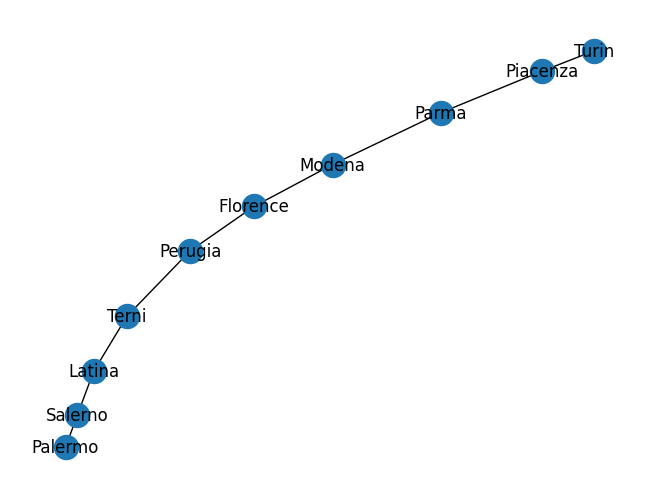

In [236]:
path: nx.Graph = a_star(G, "Palermo", "Turin", node_dist)
nx.draw(path, with_labels=True)

# Plot Interactive Graph For the country

In [ ]:
nt = Network(
    height="1000px",
    width="100%",
    bgcolor="#181818",
    font_color=True,
)
nt.from_nx(G)


# Highlight the path in the network
for edge in path.edges:
    for e in nt.edges:
        if (e["from"] == edge[0] and e["to"] == edge[1]) or (e["from"] == edge[1] and e["to"] == edge[0]):
            e["color"] = "red"


# nt.show_buttons(filter_=["nodes", "edges"])
# nt.toggle_physics(False)
for e in nt.edges:
    e["smooth"] = False
    e["label"] = f"{e["length"]:.2f} km"
    e["font"] = {"size": 8}
    e["title"] = f"Distance: {e["length"]:.2f} km"

for node in nt.nodes:
    city = COUNTRY[COUNTRY["name"] == node["label"]]
    if not city.empty:
        node["x"] = city["lon"].values[0]
        node["y"] = -city["lat"].values[0]


# Some problem in displaying the graph in the notebook
# so the graph will automatically open in the browser
nt.show("country_nodes.html", notebook=False)

# Ideally the display(HTML()) should work
# display(HTML("country_nodes.html"))

country_nodes.html
